In [8]:
import os
import torch
from torchvision import models, transforms
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt

from torchinfo import summary

In [17]:
# Charger un modèle pré-entraîné
model = models.vgg16(weights='IMAGENET1K_V1').features[:2].eval()  # Utiliser les deux premières couches pour simplifier
summary(model, input_size=torch.Size([1, 3, 224, 224]))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 64, 224, 224]         --
├─Conv2d: 1-1                            [1, 64, 224, 224]         1,792
├─ReLU: 1-2                              [1, 64, 224, 224]         --
Total params: 1,792
Trainable params: 1,792
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 89.92
Input size (MB): 0.60
Forward/backward pass size (MB): 25.69
Params size (MB): 0.01
Estimated Total Size (MB): 26.30

In [10]:
model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
)

In [27]:

# Fonction pour charger et prétraiter l'image
def load_image(image_path):
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        #transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.48235, 0.45882, 0.40784],
            std=[0.00392156862745098, 0.00392156862745098, 0.00392156862745098]
        ),
    ])
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)  # Ajouter une dimension de lot
    return image

# Charger une image exemple
DataPath = "/Users/me/Documents/Work/Dev/_data/imagenet-sample-images-master"
ImageFile = "n02391049_zebra.JPEG"
filename = os.path.join(DataPath, ImageFile)
image = load_image(filename)  # Remplacez par votre chemin d'image

# Propagation avant pour obtenir les activations
activations = model(image)

# Sélectionner une activation spécifique pour la visualisation
# Ici, nous prenons la première activation de la première feature map
activation = activations[0, 0, :, :]  # Prendre le premier canal
print(activation.size())
print(activation)

input_backward = torch.zeros_like(activations)
m = torch.argmax(activation).item()
r_max, c_max = m // activation.size(0), m % activation.size(1)
input_backward[0, 0, r_max, c_max] = activation.max().item()

torch.Size([224, 224])
tensor([[30.9046,  3.7924,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [50.9102, 19.9022,  4.5138,  ...,  0.0000,  0.0000,  0.0000],
        [64.5746, 13.4053,  8.1405,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000, 13.0680,  2.0628,  ...,  0.2969,  0.0000,  0.0000],
        [ 0.0000,  2.3427, 12.3427,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ..., 10.9094,  0.0000,  0.0000]],
       grad_fn=<SliceBackward0>)


In [32]:
# Fonction pour déconvolution / transposition de convolution
def deconv_output(output, weights, flip: bool=False):
    #deconv = torch.nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=3, stride=1, padding=1)
    #reconstructed = deconv(output)
    if flip:
        weights = torch.flip(weights, [2, 3])
    reconstructed = torch.nn.functional.conv_transpose2d(output, weights, stride=1, padding=1)
    return reconstructed

# Appliquer la déconvolution
reconstructed_image = deconv_output(input_backward, model[0].weight, flip=False)
reconstructed_image = reconstructed_image.detach().squeeze().permute(1, 2, 0)

print(reconstructed_image.min().item(), reconstructed_image.max().item())

-81.04811096191406 89.90666198730469


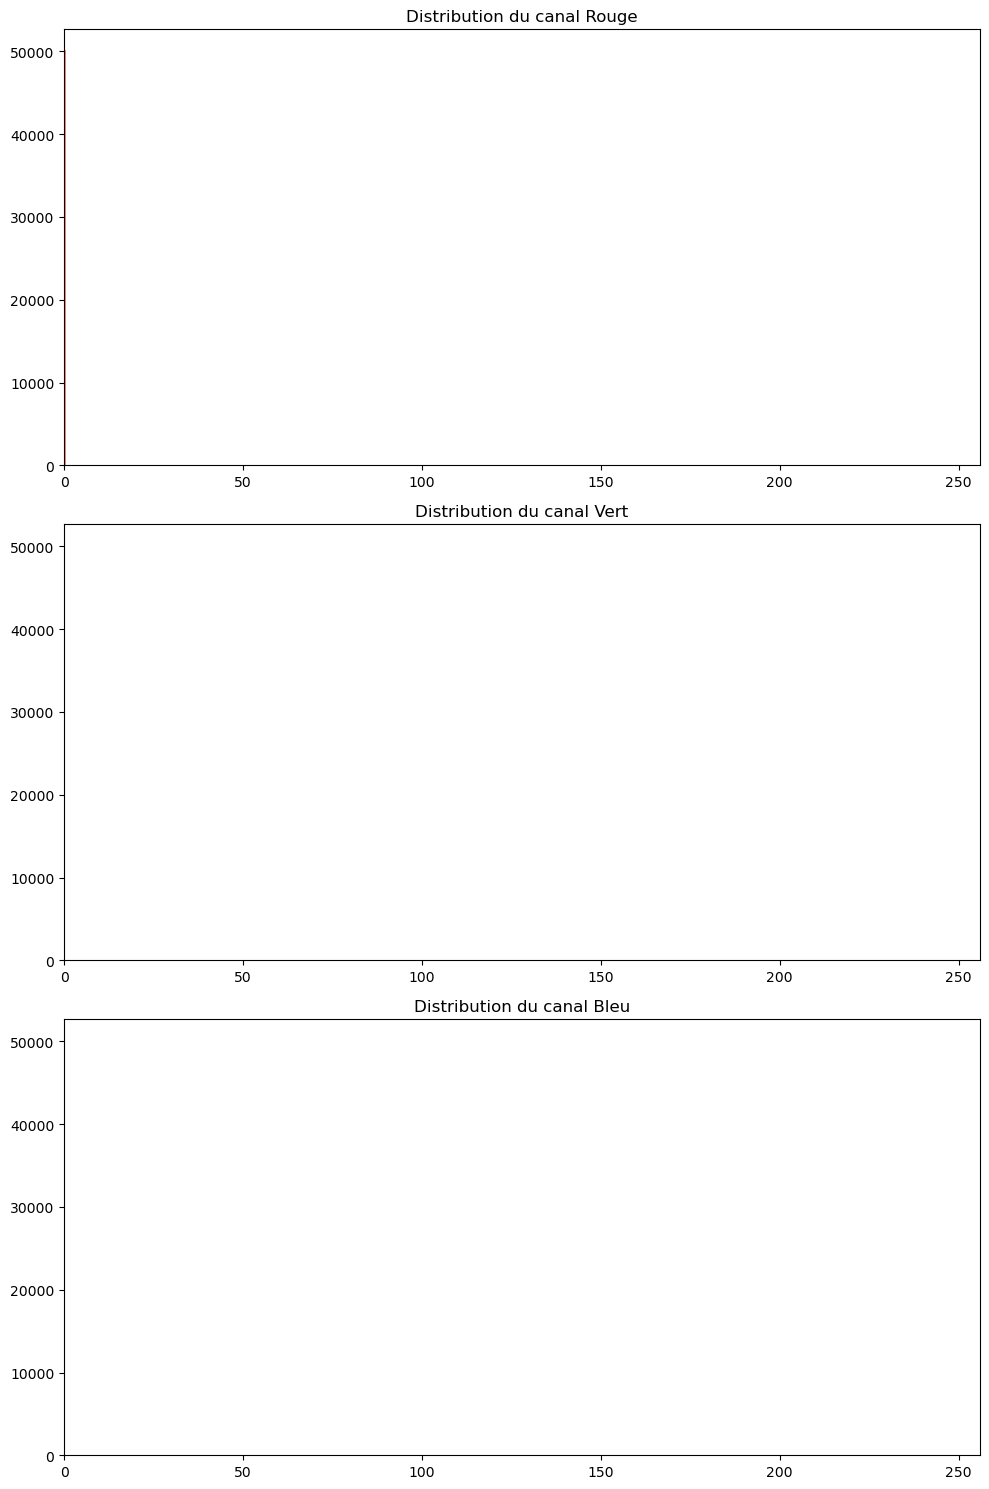

In [30]:
image_array = reconstructed_image.numpy()

# Séparer les canaux R, G et B
R = image_array[:,:,0]
G = image_array[:,:,1]
B = image_array[:,:,2]

# Créer des histogrammes pour chaque canal
fig, ax = plt.subplots(3, 1, figsize=(10, 15))

ax[0].hist(R.ravel(), bins=256, color='red', alpha=0.5)
ax[0].set_title('Distribution du canal Rouge')
ax[0].set_xlim([0, 256])

ax[1].hist(G.ravel(), bins=256, color='green', alpha=0.5)
ax[1].set_title('Distribution du canal Vert')
ax[1].set_xlim([0, 256])

ax[2].hist(B.ravel(), bins=256, color='blue', alpha=0.5)
ax[2].set_title('Distribution du canal Bleu')
ax[2].set_xlim([0, 256])

# Afficher les graphiques
plt.tight_layout()
plt.show()

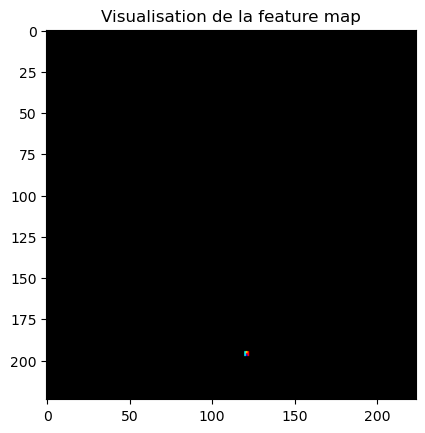

In [33]:
reconstructed_image = torch.clamp(reconstructed_image, 0, 1)
# Afficher l'image reconstruite
plt.imshow(reconstructed_image.numpy())
plt.title('Visualisation de la feature map')
plt.show()